# Controlling a Cart-Pendulum System

In [ ]:
from scipy.integrate import solve_ivp
from scipy.signal import place_poles

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

class CartPend:
  def __init__(self, m, M, L, g, b):
    self.m = m
    self.M = M
    self.L = L
    self.g = g
    self.b = b

    # Linearized Pendulum System
    A = np.array(
    [[0, 1, 0, 0],
     [0, -b/M, m*g/M, 0],
     [0, 0, 0, 1],
     [0, -b/(M*L), (m+M)*g/(M*L), 0]])

    B = np.reshape([0, 1/M, 0, 1/(M*L)], (4, 1))

    self.A = A
    self.B = B

  def response(self, x0, start, end, n, K=np.zeros(4).T, r=np.zeros(4), linear=False):
    if linear:
      return solve_ivp(lambda t,y: self.linear_pend(t,y,K,r), (start, end), x0, t_eval=np.linspace(start,end,n))
    else:
      return solve_ivp(lambda t,y: self.nonlinear_pend(t,y,K,r), (start, end), x0, t_eval=np.linspace(start,end,n))

  def linear_pend(self, t, x, K, r):
    u = -K.dot(x-r)
    return self.A.dot(x) + self.B.dot(u)

  def nonlinear_pend(self, t, x, K, r):
    u = -K.dot(x-r)
    m,M,L,g,b = self.m, self.M, self.L, self.g, self.b

    sin = np.sin(x[2])
    cos = np.cos(x[2])
    D = m*L*L*(M+m*sin**2)

    f1 = x[1]
    f2 = (1/D)*(m**2*L**2*g*sin*cos + m*L*L*(m*L*x[3]**2*sin - b*x[1])) + m*L*L*(1/D)*u
    f3 = x[3]
    f4 = (1/D)*((m+M)*m*g*L*sin - m*L*cos*(m*L*x[3]**2*sin + b*x[1])) + m*L*cos*(1/D)*u + 0.01 * np.random.normal(0,1)
    return f1,f2,f3,f4

  @staticmethod
  def plot_response(sol):
    plt.figure(figsize=(10,7))
    plt.subplot(221)
    plt.plot(sol.t,sol.y[0],'m',lw=2)
    plt.legend([r'$y$'],loc=1)
    plt.ylabel('y')
    plt.xlabel('Time (s)')
    plt.title('Position (m)')
    plt.xlim(0,10)

    plt.subplot(222)
    plt.plot(sol.t,sol.y[1],'g',lw=2)
    plt.legend([r'$v$'],loc=1)
    plt.ylabel('v')
    plt.xlabel('Time (s)')
    plt.title('Velocity (m/s)')
    plt.xlim(0,10)

    plt.subplot(223)
    plt.plot(sol.t,sol.y[2],'r',lw=2)
    plt.legend([r'$\theta$'],loc=1)
    plt.ylabel(r'$\theta$')
    plt.xlabel('Time (s)')
    plt.title('Angle (rad)')
    plt.xlim(0,10)

    plt.subplot(224)
    plt.plot(sol.t,sol.y[3],'y',lw=2)
    plt.legend([r'$\omega$',r'$q$'],loc=1)
    plt.xlabel('Time (s)')
    plt.ylabel(r'$\omega$')
    plt.title('Angular Velocity (rad/s)')
    plt.xlim(0,10)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,2))

    plt.tight_layout
    plt.subplots_adjust(left=1,right=2, top=1, wspace=0.2, hspace=0.35);


  # Source: https://apmonitor.com/do/index.php/Main/InvertedPendulum
  def simulate(self, K, r, start, end, ylim=(-0.8,2), n=200, x0=None):
    # n = 200
    # tf = 20.0
    # m.time = np.linspace(0,tf,n)
    tf = end-start
    if x0 is None:
      x0 = np.zeros(4)
    sol = self.response(x0, start, end, n, K=K, r=r, linear=False)
    time = np.linspace(0, tf, n)

    y = sol.y[0]
    v = sol.y[1]
    theta = sol.y[2]
    omega = sol.y[3]

    x1 = y
    y1 = np.zeros(n)

    #suppose that l = 1
    x2 = 1*np.sin(theta)+x1
    x2b = 1.05*np.sin(theta)+x1
    y2 = 1*np.cos(theta)-y1
    y2b = 1.05*np.cos(theta)-y1

    fig = plt.figure(figsize=(8,6.4))
    ax = fig.add_subplot(111,autoscale_on=False,\
                         xlim=ylim,ylim=(-0.4,1.2))
    ax.set_xlabel('position')
    ax.get_yaxis().set_visible(False)

    crane_rail, = ax.plot([ylim[0]-0.4,ylim[1]+0.4],[-0.2,-0.2],'k-',lw=4)
    start, = ax.plot([0,0],[-0.5,1.5],'k:',lw=2)
    objective, = ax.plot([1,1],[-0.5,1.5],'k:',lw=2)
    mass1, = ax.plot([],[],linestyle='None',marker='s',\
                     markersize=40,markeredgecolor='k',\
                     color='orange',markeredgewidth=2)
    mass2, = ax.plot([],[],linestyle='None',marker='o',\
                     markersize=20,markeredgecolor='k',\
                     color='orange',markeredgewidth=2)
    line, = ax.plot([],[],'o-',color='orange',lw=4,\
                    markersize=6,markeredgecolor='k',\
                    markerfacecolor='k')
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05,0.9,'',transform=ax.transAxes)
    wgt_template = 'weight = %.1f'
    wgt_text = ax.text(0.75,0.9,'',transform=ax.transAxes)
    start_text = ax.text(-0.1,-0.3,'start',ha='right')
    end_text = ax.text(1.1,-0.3,'objective',ha='left')

    def init():
        mass1.set_data([],[])
        mass2.set_data([],[])
        line.set_data([],[])
        time_text.set_text('')
        wgt_text.set_text('')
        return line, mass1, mass2, time_text, wgt_text

    def animate(i):
        mass1.set_data([x1[i]],[y1[i]-0.1])
        mass2.set_data([x2b[i]],[y2b[i]])
        line.set_data([x1[i],x2[i]],[y1[i],y2[i]])
        time_text.set_text(time_template % time[i])
        return line, mass1, mass2, time_text

    ani_a = animation.FuncAnimation(fig,animate,np.arange(1,n),interval=30,blit=False,init_func=init)
    plt.close(fig);

    return ani_a


## Setup (DO NOT CHANGE THESE PARAMETERS)

The cell below sets up the parameters for the mass, length, and damping ratio.

In [ ]:
m = 1
M = 5
L = 2
g = 10
b = 1

A = np.array(
  [[0, 1, 0, 0],
   [0, -b/M, m*g/M, 0],
   [0, 0, 0, 1],
   [0, -b/(M*L), (m+M)*g/(M*L), 0]])

B = np.reshape([0, 1/M, 0, 1/(M*L)], (4, 1))

cart_pend = CartPend(m, M, L, g, b)

## Part (c)

Show that the linearized pendulum-cart system is controllable but unstable. You can either work it out by hand or fill in the cells below.

The functions `np.column_stack` and `np.linalg.eig` may be helpful.

In [ ]:
##### Workspace #####
# C =
# print('The rank of the controllabilty matrix is {}.'.format(np.linalg.matrix_rank(C)))

# eigs =
# print('The eigenvalues of the state matrix are {}.'.format(eigs))

Let's see what happens if we push the pendulum very slightly by giving input $u = 0.01$

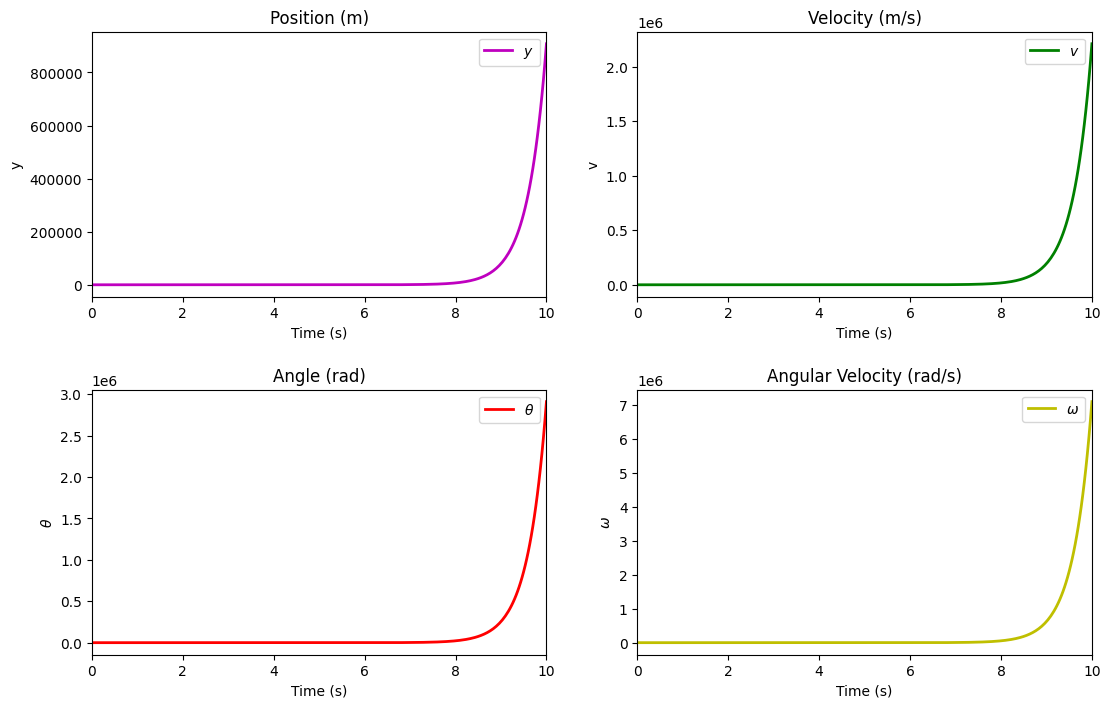

In [ ]:
def exponential_decay(t,x):
  u = [0.01]
  return A.dot(x) + B.dot(u)

sol = solve_ivp(exponential_decay, (0, 10), (0, 0, 0, 0), t_eval=np.linspace(0,10,300))
CartPend.plot_response(sol)

<b>In your written submission, explain what happens when the cart-pendulum when a small force input is applied.</b>

## Part (d)

Since the system is controllable, we can use state-feedback to place the eigenvalues anywhere in the complex plane.

<b> Find the values of K by hand or by filling in the cells below to make the eigenvalues of the closed-loop matrix equal to [-2, -1.4, -1.2, -1.3] </b>  

When implementing this in practice, we can use the `place_poles` function from the scipy.signal library: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.place_poles.html

In [ ]:
## YOUR CODE HERE ##

eigs = [-2.0, -1.4, -1.2, -1.3]
poles = place_poles(A, B, eigs)
print(poles.computed_poles)
K = poles.gain_matrix
print(K)

[-2.  -1.4 -1.3 -1.2]
[[ -4.368 -13.304 197.336  83.608]]


Now that we have picked the eigenvalues of our system, let's see how the linearized system behaves for $t \in [0, 10].$

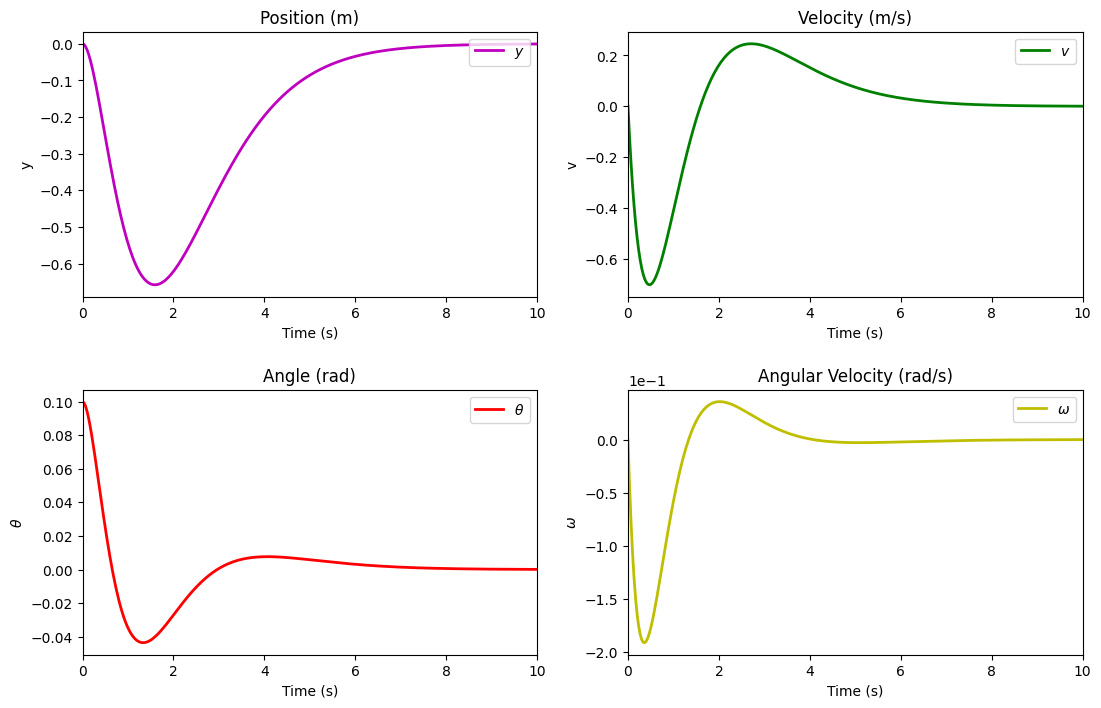

In [ ]:
def linearized_response(t,x):
  u = -K.dot(x)
  return A.dot(x) + B.dot(u)

sol = solve_ivp(linearized_response, (0, 10), (0, 0, 0.1, 0), t_eval=np.linspace(0,10,300))
CartPend.plot_response(sol)

As a sanity check, let's make sure the nonlinear system behaves in a similar fashion.

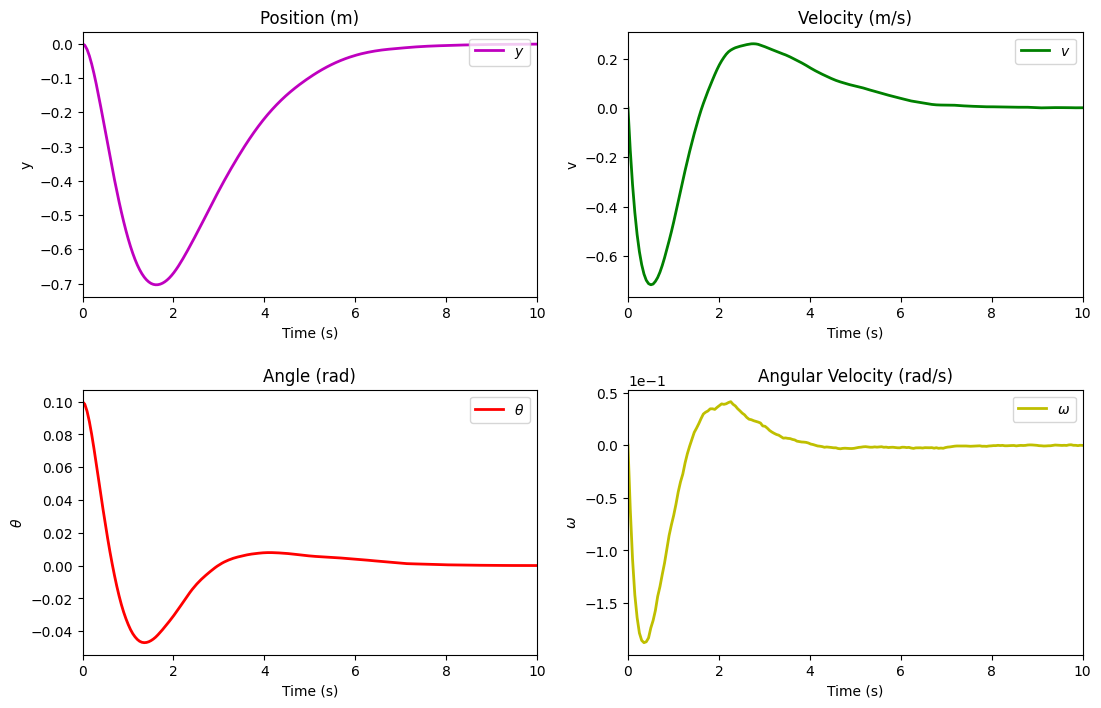

In [ ]:
def nonlinear_response(t, x):
  u = -K.dot(x)
  sin = np.sin(x[2])
  cos = np.cos(x[2])
  D = m*L*L*(M+m*sin**2)

  f1 = x[1]
  f2 = (1/D)*(m**2*L**2*g*sin*cos + m*L*L*(m*L*x[3]**2*sin - b*x[1])) + m*L*L*(1/D)*u
  f3 = x[3]
  f4 = (1/D)*((m+M)*m*g*L*sin - m*L*cos*(m*L*x[3]**2*sin + b*x[1])) + m*L*cos*(1/D)*u + 0.05*np.random.normal(0,1)
  return f1,f2,f3,f4

sol = solve_ivp(nonlinear_response, (0, 10), (0, 0, 0 + 0.1, 0), t_eval=np.linspace(0,10,200))
CartPend.plot_response(sol)

## Part (f) ##

### Applying a reference input $\vec{r}$

In part (e) we showed that if our target $\vec{r} \in \mbox{Nul}(A)$ then the error $\vec{e}(t)$ converges to $\vec{0}$ meaning the state $\vec{x}$ will reach the target $\vec{r}.$

Now let's try to move our cart-pendulum system from $\vec{0}$ to the state $\vec{r} = \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \end{bmatrix}.$

Since $\vec{r} \in \mbox{Nul}(A)$ we can apply an input $u = -K (\vec{x} - \vec{r})$ to drive the steady-state error to zero.

In [ ]:
r = np.array([0, 0, 0, 0])

The plots of the linearized response are shown below.

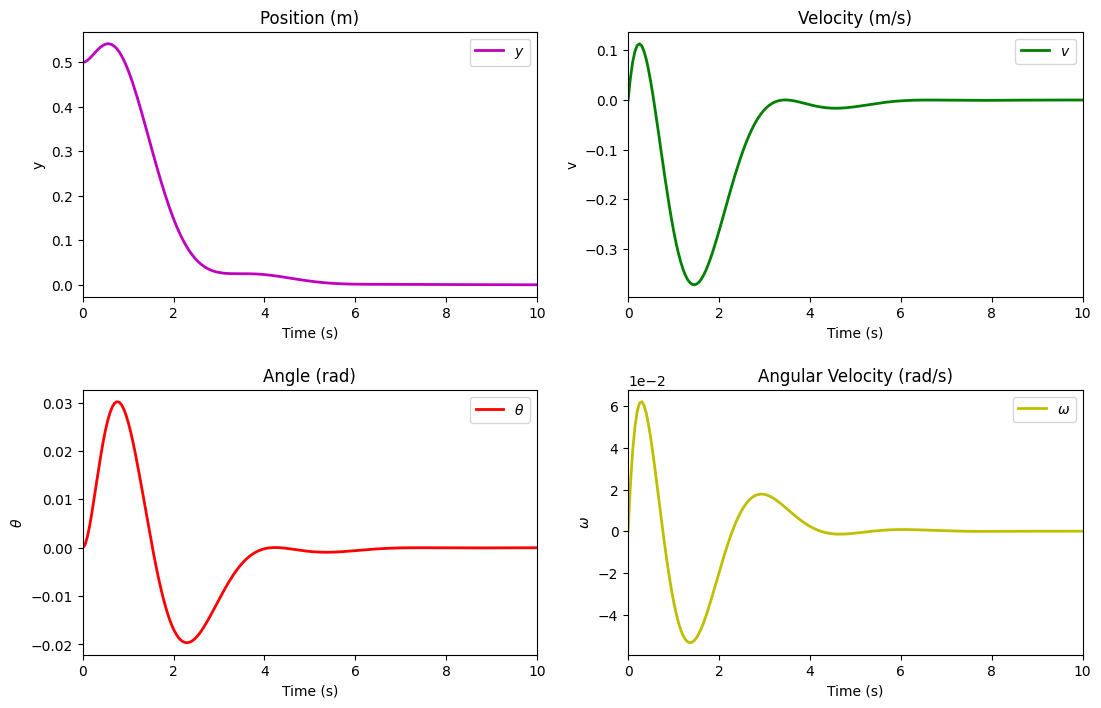

In [ ]:
n = 200
start, end = 0, 10
x0 = np.zeros(4)
x0[0] = 0.5

sol = cart_pend.response(x0, start, end, n, K=K, r=r, linear=True)
CartPend.plot_response(sol)

### Eigenvalue Placement ###

Since the linearized system is a good approximation of the nonlinear cart-pendulum system, we can take the following steps.
1. Pick our favorite choice of eigenvalues $\lambda_{1}$ to $\lambda_{4},$ for the linearized system.
2. Find the appropriate $K$ values to place the eigenvalues of the closed-loop matrix $A_{cl} = (A - BK)$ at $\lambda_{i}.$
3. Apply the input $u = K(\vec{r} - \vec{x})$ to the original nonlinear system.

Try tweaking the eigenvalues of the system and running the simulation to see how the cart-pendulum system behaves.
Note that the eigenvalues need to be distinct for `place_poles` to solve for $K.$

You may also need to install ffmpeg to play the simulation video

<font color='red'><b>Warning: If the values of $K$ become too large the differential equation solver will break.<b></font>

Feedback gain matrix K = [[-10. -20. 210.  88.]]


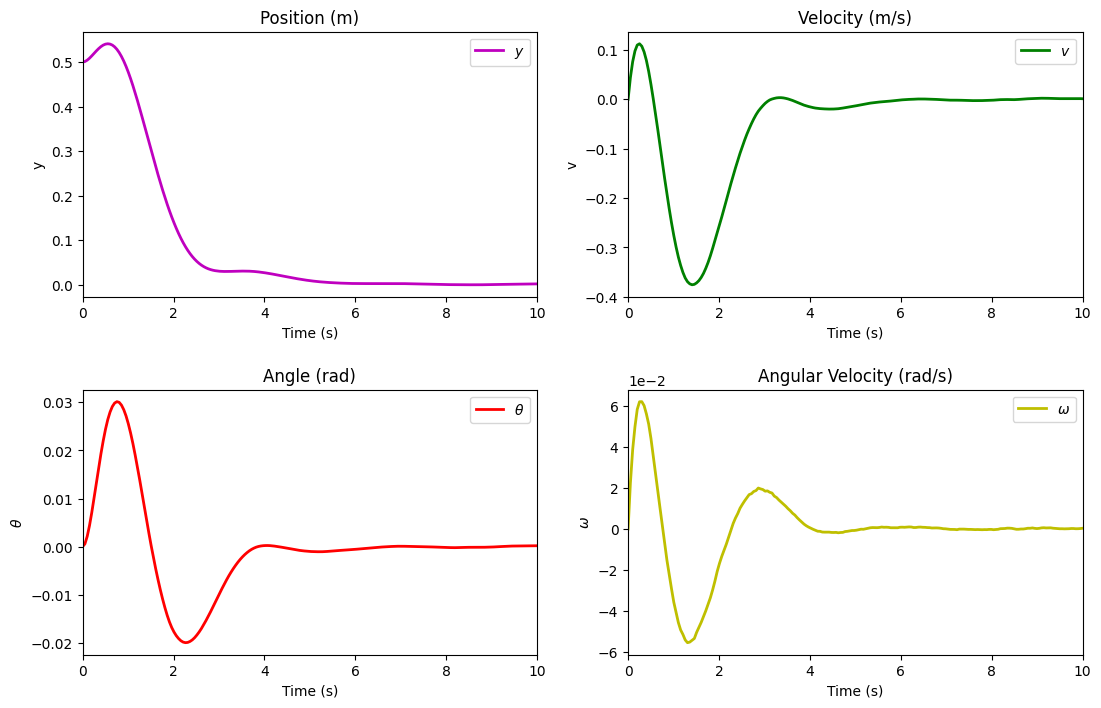

In [ ]:
from IPython.display import HTML

# Values are filled in as a reference. Try to keep your eigenvalues distinct.
eigs = [-2, -1, -1+2j, -1-2j] ## CHANGE THESE VALUES

K = place_poles(A, B, eigs).gain_matrix
print('Feedback gain matrix K = {}'.format(K))

# Code to generate response plots. Feel free to change start, end, and n.
start, end, n = 0, 10, 200
sol = cart_pend.response(x0, start, end, n, K=K, r=r, linear=False)
CartPend.plot_response(sol)

In [ ]:
# You can change the length of the simulation and ylim sets the x-axis of the plot.
anim = cart_pend.simulate(K, r, start=0.0, end=8.0, ylim=(-1, 2) ,n=n, x0=x0);

# May require installing ffmpeg
HTML(anim.to_html5_video())

<b> In your written submission, explain the effect that the eigenvalues have on the system. </b> What was your favorite pair of eigenvalues?

## Final Remarks ###

Congratulations on reaching the end of this homework problem. Hopefully you were able to see the end-to-end process of analyzing and controlling a system by taking the following steps:
1. Linearizing the nonlinear system around an equilibrium point.
2. Determining whether the system was controllable.
3. Realizing the system was unstable.
4. Using feedback control to stabilize the system and move it to a desired target.

Since we simulated the cart-pendulum system, there were still some nonidealities such as noise and saturation that we didn't take into account. When implementing this system in the real world, we won't always get the freedom of picking arbitrarily large K values.

If you take EE128, you will get to implement the cart-pendulum system in the lab! On the other hand, if you take EE127, you can learn about ways to pick K values that have the least "cost" by using a technique called the Linear Quadratic Regulator or LQR.

# Discretization (zero-order hold)

https://www.eecs16b.org/notes/fa23/note10.pdf


In [ ]:
from scipy.signal import cont2discrete
C = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0]
])

D = np.array([[0]]) # C and D aren't strictly necessary for us, but include anyways
system = (A, B, C, D)
dt = 0.01
A_d, B_d, C_d, D_d, _ = cont2discrete(system, dt, method='zoh')

In [ ]:
print(A_d)
print(B_d)

[[ 1.00000000e+00  9.99000658e-03  9.99383644e-05  3.33176730e-07]
 [ 0.00000000e+00  9.98001965e-01  1.99820122e-02  9.99383644e-05]
 [ 0.00000000e+00 -4.99691822e-06  1.00029998e+00  1.00009999e-02]
 [ 0.00000000e+00 -9.99100611e-04  5.99960058e-02  1.00029998e+00]]
[[9.99341993e-06]
 [1.99803463e-03]
 [4.99691822e-06]
 [9.99100611e-04]]


In [ ]:
desired_poles = [0.94, 0.95, 0.96, 0.93] # idk why is this so hard man
poles = place_poles(A_d, B_d, desired_poles)
K_d = poles.gain_matrix
print(K_d)

def discrete_stabilized_sim(A_d, B_d, K_d, x_0, timesteps=200):
  states = []
  x = x_0
  states.append(x)
  for _ in range(timesteps):
    u = -K_d.dot(x)
    x = A_d.dot(x) + B_d.dot(u)
    states.append(x)
  return states

[[-840.79823925 -626.9929068  3470.245413   1463.73385504]]


In [ ]:
x_0 = np.array([0.5, 0, 0, 0])
all_states = np.array(discrete_stabilized_sim(A_d, B_d, K_d, x_0))
xs = all_states[:, 0]
vs = all_states[:, 1]
thetas = all_states[:, 2]
ws = all_states[:, 3]
print(all_states)

[[ 5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.04201225e-01  8.39972001e-01  2.10070002e-03  4.20021017e-01]
 [ 5.15875730e-01  1.49473016e+00  7.93924604e-03  7.47637446e-01]
 [ 5.33297890e-01  1.98956603e+00  1.66557094e-02  9.95659919e-01]
 [ 5.54981067e-01  2.34698643e+00  2.75110981e-02  1.17546680e+00]
 [ 5.79651116e-01  2.58698452e+00  3.98737409e-02  1.29714539e+00]
 [ 6.06222482e-01  2.72728642e+00  5.32070199e-02  1.36962034e+00]
 [ 6.33776655e-01  2.78357563e+00  6.70583273e-02  1.40077028e+00]
 [ 6.61542762e-01  2.76969700e+00  8.10491366e-02  1.39753379e+00]
 [ 6.88880108e-01  2.69784210e+00  9.48660825e-02  1.36600553e+00]
 [ 7.15262484e-01  2.57871754e+00  1.08252959e-01  1.31152350e+00]
 [ 7.40264086e-01  2.42169771e+00  1.21003548e-01  1.23874803e+00]
 [ 7.63546881e-01  2.23496337e+00  1.32955203e-01  1.15173345e+00]
 [ 7.84849301e-01  2.02562714e+00  1.43983108e-01  1.05399287e+00]
 [ 8.03976130e-01  1.79984729e+00  1.53995168e-01  9.48556797e

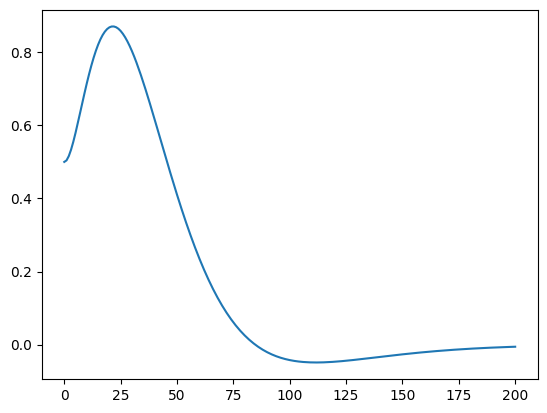

In [ ]:
plt.plot(xs)
plt.show()

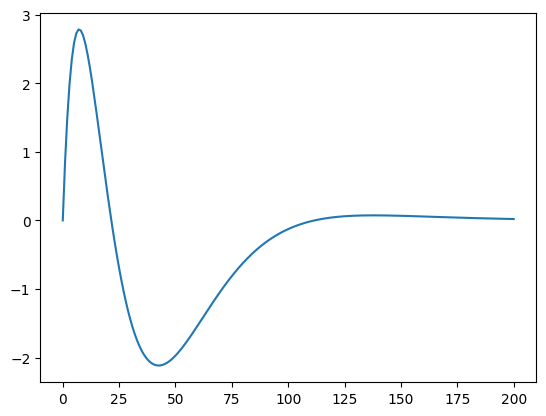

In [ ]:
plt.plot(vs)
plt.show()

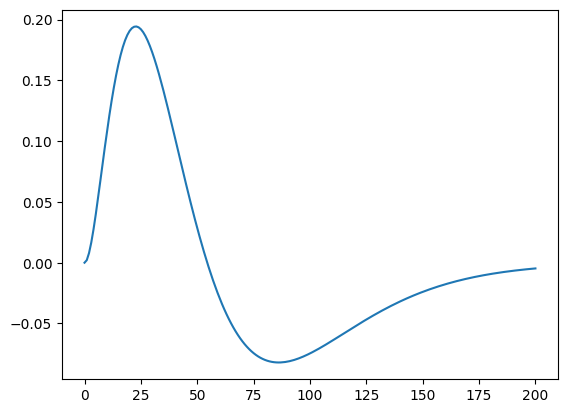

In [ ]:
plt.plot(thetas)
plt.show()

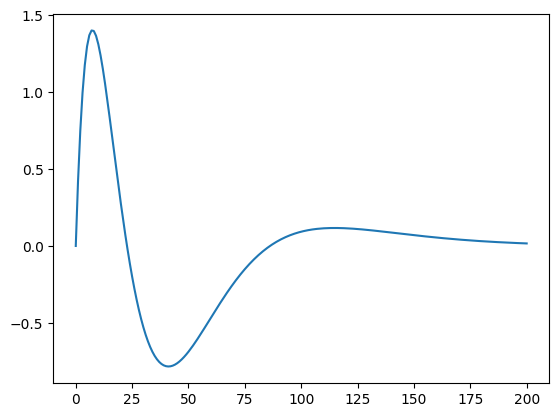

In [ ]:
plt.plot(ws)
plt.show()

In [ ]:
A_d = np.array([
    [1.0, 0.00999, 0.000099938, 0.00000033317],
    [0.0, 0.998, 0.01998, 0.000099938],
    [0.0, -0.0000049969, 1.000299, 0.01],
    [0.0, -0.0009991, 0.059996, 1.00029998]
])

B_d = np.array([
    [0.000009993],
    [0.001998],
    [0.0000049969],
    [0.0009991]
]);

K_d = np.array([
    [-840.798, -626.993, 3470.245, 1463.734]
])

In [ ]:
print(np.linalg.eig(A_d - B_d @ K_d))

(array([0.92882841, 0.94296904, 0.94788286, 0.96029567]), array([[ 0.11762938, -0.14495444,  0.15711736,  0.19458603],
       [-0.86809596,  0.85097027, -0.84077495, -0.78825338],
       [ 0.06474718, -0.08475886,  0.0951568 ,  0.1398941 ],
       [-0.47789176,  0.49764822, -0.50927086, -0.56676497]]))
